# Time Series Forecasting with Dart TCN model

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from darts import TimeSeries
from typing import Optional
from darts import models, backtesting
from darts.preprocessing import ScalerWrapper
from darts.utils import missing_values
from custom_code import sumape, create_fortnights
%matplotlib inline

In [2]:
pd.plotting.register_matplotlib_converters()


# Dart

In [3]:
df = pd.read_csv("efecty_drawdowns.csv", dtype={"y":float, "entity_id":int, "ds":str}, index_col=0)
df["ds"] = pd.to_datetime(df["ds"], format='%Y-%m-%d')
df.head()

,ds,y,entity_id
0,2019-02-05,3383730.0,995152
1,2019-02-05,988994.0,992133
2,2019-02-05,597150.0,995388
3,2019-02-05,50000.0,902343
4,2019-02-05,1426410.0,993733


In [4]:
len(df.entity_id.unique())

254

In [5]:
df_995388 = df[df.entity_id == 995388]
df_995388["y"].isna().sum() 

0

In [6]:
df_995388.loc[df_995388["ds"] =="2020-01-01"]

,ds,y,entity_id


In [7]:
df_995388

,ds,y,entity_id
2,2019-02-05,597150.0,995388
355,2019-02-06,749804.0,995388
422,2019-02-07,969965.0,995388
703,2019-02-08,770000.0,995388
826,2019-02-09,621000.0,995388
...,...,...,...
72022,2020-02-25,2263630.0,995388
72235,2020-02-26,694000.0,995388
72522,2020-02-27,200000.0,995388
72931,2020-02-28,430000.0,995388


## Plot one entity

<AxesSubplot:xlabel='ds'>

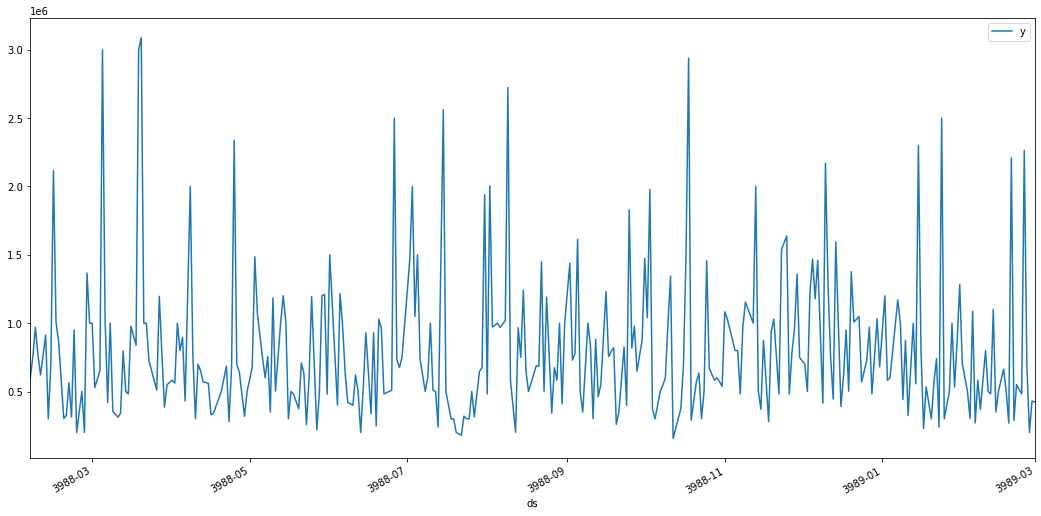

In [8]:
df_995388.plot(x="ds", y="y", figsize=(18,9))

In [9]:
df_995388.iloc[300]

ds           2020-02-08 00:00:00
y                         370000
entity_id                 995388
Name: 68468, dtype: object

## Fill missing values
TimeSeries add missing date with nan values, and you have to fillna values with `auto_fillna` function

In [10]:
date_division = "20191215"
series = TimeSeries.from_dataframe(df_995388, "ds", "y" )
series = missing_values.auto_fillna(series, method="slinear")
train, val = series.split_after(pd.Timestamp(date_division))
len(train) + len(val)

390

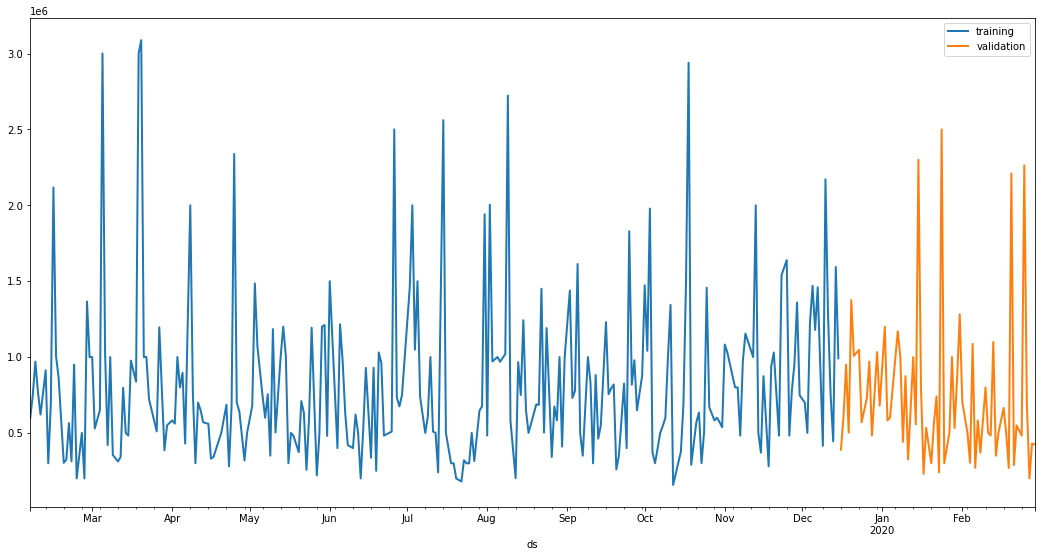

In [11]:
train.plot(lw=2, label='training', figsize=(18,9))
val.plot(lw=2, label='validation', figsize=(18,9))
plt.legend();

In [12]:
df_995388["y"].isna().sum() 

0

(datetime.date(2020, 2, 29),)

## TCN univariant

In [17]:
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
ts_transformed = transformer.transform(series)

In [18]:
my_model = models.TCNModel(
    n_epochs=1000, 
    input_length=20, 
    output_length=5, 
    dropout=0.1, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=5,
    num_filters=3
)

[2020-07-21 11:00:39,150] INFO | darts.models.tcn_model | Number of layers chosen: 2


In [19]:
my_model.fit(train_transformed, val_series=val_transformed, verbose=False)

In [20]:
prediction = my_model.predict(len(val))

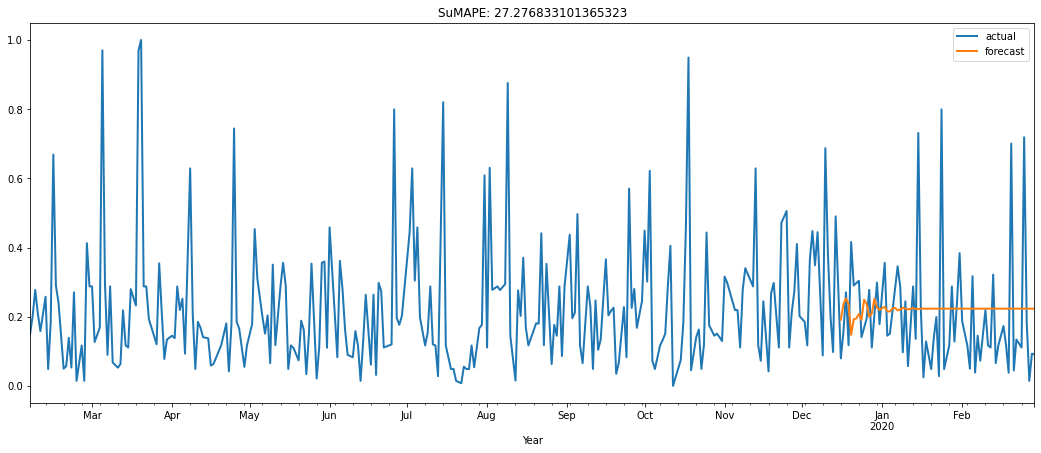

In [21]:
ts_transformed.plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")
plt.title('SuMAPE: {}'.format(sumape(prediction.slice_intersect(val_transformed), val_transformed)))
plt.legend();

## Grid search for fine tunning
TODO need more compute time!

In [57]:
backtesting.backtest_gridsearch(
    model_class = models.TCNModel,
    parameters = {
        "n_epochs":[1000],
        "input_length":[15,30,45], 
        "output_length":[3,7], 
        "dropout":[0.1], 
        "dilation_base":[2], 
        "weight_norm":[True],
        "kernel_size":[3,7,15],
        "num_filters":[3,5]
        }, 
    train_series = ts_transformed, 
    fcast_horizon_n = 15, 
    metric = sumape, 
    verbose = True
    )

[2020-07-20 16:59:54,475] INFO | darts.models.tcn_model | Number of layers chosen: 3



KeyboardInterrupt: 

## Multivariant TCN

In [24]:
# Create training and validation sets:
ts_enhanced = series.add_datetime_attribute('weekday', True)
ts_enhanced = ts_enhanced.add_holidays(country_code="COL")
# TODO add quincena column
train, val = ts_enhanced.split_after(pd.Timestamp(date_division))
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
ts_transformed = transformer.transform(ts_enhanced)
ts_transformed

                   0    1    2    3    4    5    6    7    8
ds                                                          
2019-02-05  0.150124  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2019-02-06  0.202214  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2019-02-07  0.277339  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
2019-02-08  0.209106  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2019-02-09  0.158262  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
...              ...  ...  ...  ...  ...  ...  ...  ...  ...
2020-02-25  0.718776  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2020-02-26  0.183172  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2020-02-27  0.014605  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
2020-02-28  0.093087  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2020-02-29  0.091130  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0

[390 rows x 9 columns]
Freq: D

In [25]:
# Create TCNModel instance
my_model = models.TCNModel(
    input_size=9,
    n_epochs=1000,
    input_length=20,
    output_length=8,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=4,
    num_filters=3
)

# Fit model
my_model.fit(train_transformed, val_series=val_transformed, target_indices=[0], verbose=True)

[2020-07-21 11:08:21,831] INFO | darts.models.tcn_model | Number of layers chosen: 3


Training loss: 0.4428, validation loss: 0.2664Training loss: 0.2275, validation loss: 0.0954Training loss: 0.1745, validation loss: 0.0850Training loss: 0.1571, validation loss: 0.0833Training loss: 0.1482, validation loss: 0.0825Training loss: 0.1413, validation loss: 0.0817Training loss: 0.1365, validation loss: 0.0811Training loss: 0.1290, validation loss: 0.0813Training loss: 0.1241, validation loss: 0.0807Training loss: 0.1239, validation loss: 0.0808Training loss: 0.1208, validation loss: 0.0803Training loss: 0.1147, validation loss: 0.0804Training loss: 0.1160, validation loss: 0.0800Training loss: 0.1153, validation loss: 0.0797Training loss: 0.1148, validation loss: 0.0797Training loss: 0.1139, validation loss: 0.0798Training loss: 0.1127, validation loss: 0.0803Training loss: 0.1123, validation loss: 0.0804Training loss: 0.1105, validation loss: 0.0817Training loss: 0.1087, validation loss: 0.0813Training loss: 0.1091, validation loss: 0.0818Training loss: 0.1065, validation 

In [30]:
best_model = models.TCNModel.load_from_checkpoint(model_name="torch_model_run", best=True)


loading model_best_130.pth.tar


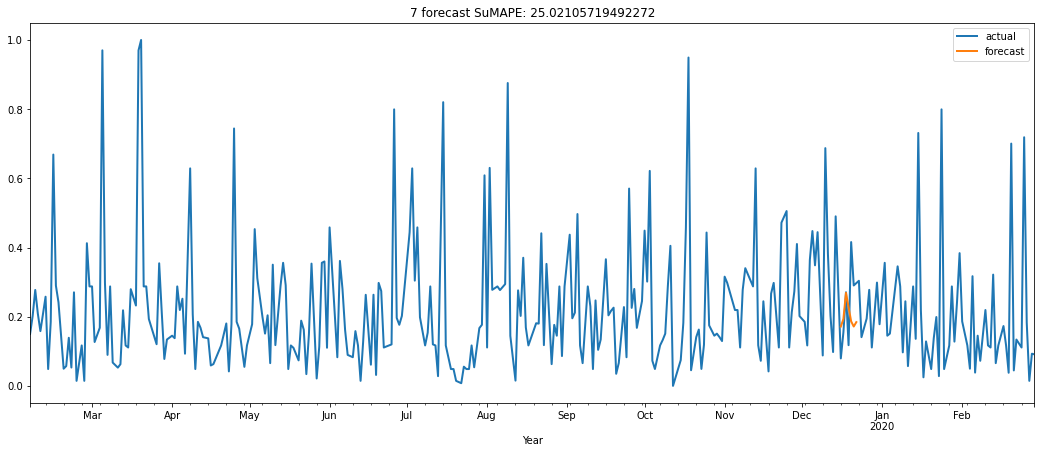

In [31]:
#Evaluate model
prediction = best_model.predict(7, True)
ts_transformed.univariate_component(0).plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")
plt.title('7 forecast SuMAPE: {}'.format(sumape(prediction.slice_intersect(val_transformed), val_transformed.univariate_component(0))))
plt.legend();

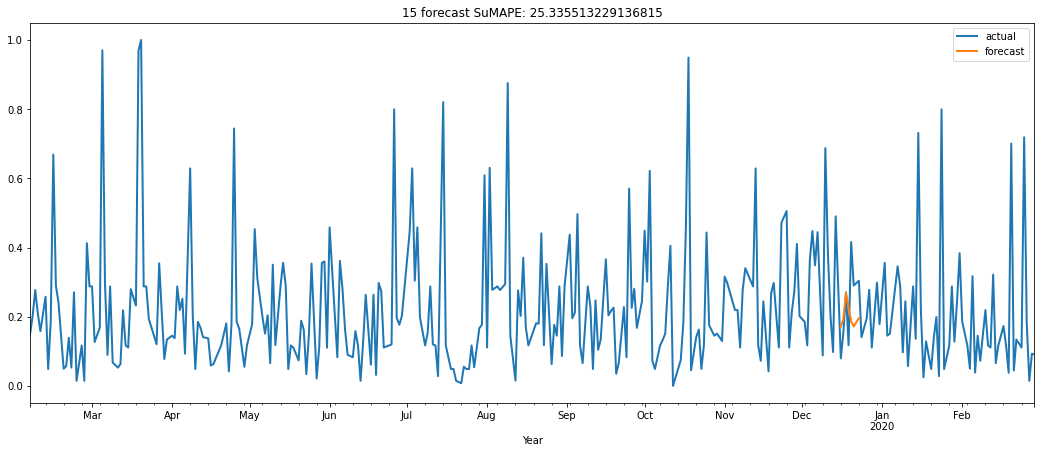

In [32]:
#Evaluate model
prediction = best_model.predict(8, True)
ts_transformed.univariate_component(0).plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")
plt.title('15 forecast SuMAPE: {}'.format(sumape(prediction.slice_intersect(val_transformed), val_transformed.univariate_component(0))))
plt.legend();

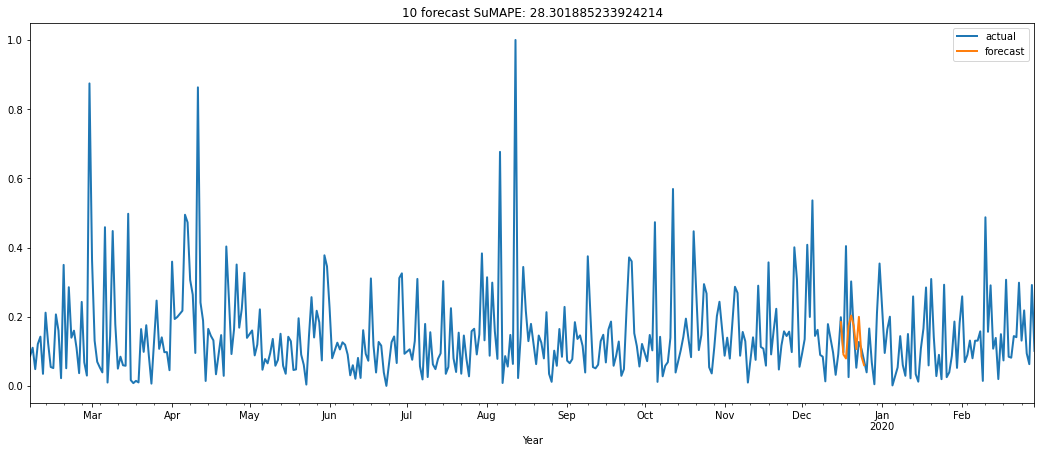

In [35]:

#Evaluate model
prediction = my_model.predict(10, use_full_output_length=True)
ts_transformed.univariate_component(0).plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")
plt.title('10 forecast SuMAPE: {}'.format(sumape(prediction.slice_intersect(val_transformed), val_transformed.univariate_component(0))))
plt.legend();

### Add quincenas

In [84]:
## Create a empty df with 0 values and a quincenas df with quincena date and 1, update them and create a TimeSeries to stack it.
df_quincenas = create_fortnights(series.pd_dataframe().index[0].date(), series.pd_dataframe().index[-1].date())
df_quincenas.set_index("ds", inplace=True)
df_quincenas.replace(to_replace="quincena", value=1, inplace=True)

df_quincena_full = pd.DataFrame({
    "ds":pd.date_range(start=series.pd_dataframe().index[0].date(), end=series.pd_dataframe().index[-1].date()),
    "holiday":0
})
df_quincena_full.set_index("ds", inplace=True)
df_quincena_full.update(df_quincenas)

In [86]:
quincena_ts = TimeSeries.from_dataframe(df_quincena_full, time_col=None, value_cols="holiday" )

In [91]:
# Create training and validation sets:
ts_enhanced = series.add_holidays(country_code="COL")
ts_enhanced = ts_enhanced.stack(quincena_ts)
train, val = ts_enhanced.split_after(pd.Timestamp(date_division))
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
ts_transformed = transformer.transform(ts_enhanced)
ts_transformed

                   0    1    2
ds                            
2019-02-05  0.150124  0.0  0.0
2019-02-06  0.202214  0.0  0.0
2019-02-07  0.277339  0.0  0.0
2019-02-08  0.209106  0.0  0.0
2019-02-09  0.158262  0.0  0.0
...              ...  ...  ...
2020-02-25  0.718776  0.0  0.0
2020-02-26  0.183172  0.0  0.0
2020-02-27  0.014605  0.0  0.0
2020-02-28  0.093087  0.0  1.0
2020-02-29  0.091130  0.0  0.0

[390 rows x 3 columns]
Freq: D

In [92]:
# Create TCNModel instance
my_model = models.TCNModel(
    input_size = 3 ,
    n_epochs = 1000,
    input_length = 20,
    output_length = 8,
    dropout = 0.1,
    dilation_base = 2,
    weight_norm = True,
    kernel_size=4,
    num_filters=3
)

# Fit model
my_model.fit(train_transformed, val_series=val_transformed, target_indices=[0], verbose=True)

[2020-07-22 12:14:39,108] INFO | darts.models.tcn_model | Number of layers chosen: 3


Training loss: 0.1832, validation loss: 0.1073Training loss: 0.1307, validation loss: 0.0909Training loss: 0.1181, validation loss: 0.0908Training loss: 0.1149, validation loss: 0.0925Training loss: 0.1124, validation loss: 0.0928Training loss: 0.1105, validation loss: 0.0934Training loss: 0.1082, validation loss: 0.0946Training loss: 0.1074, validation loss: 0.0963Training loss: 0.1080, validation loss: 0.0960Training loss: 0.1064, validation loss: 0.0975Training loss: 0.1032, validation loss: 0.0984Training loss: 0.1009, validation loss: 0.1000Training loss: 0.1028, validation loss: 0.1003Training loss: 0.1029, validation loss: 0.0983Training loss: 0.1023, validation loss: 0.0996Training loss: 0.1022, validation loss: 0.0998Training loss: 0.0978, validation loss: 0.0982Training loss: 0.0964, validation loss: 0.0998Training loss: 0.0973, validation loss: 0.1002Training loss: 0.0983, validation loss: 0.0993Training loss: 0.0971, validation loss: 0.0995Training loss: 0.0962, validation 

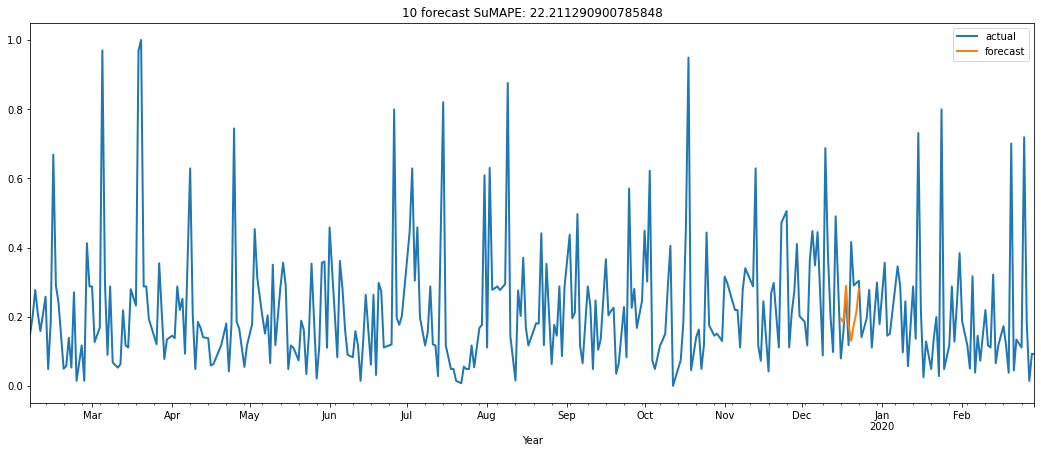

In [94]:
#Evaluate model
prediction = my_model.predict(8, use_full_output_length=True)
ts_transformed.univariate_component(0).plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")
plt.title('10 forecast SuMAPE: {}'.format(sumape(prediction.slice_intersect(val_transformed), val_transformed.univariate_component(0))))
plt.legend();

In [106]:
# Create TCNModel instance
my_model_2 = models.TCNModel(
    input_size = 3 ,
    n_epochs = 1000,
    input_length = 15,
    output_length = 12,
    dropout = 0.1,
    dilation_base = 1,
    weight_norm = True,
    kernel_size = 7,
    num_filters = 4
)

# Fit model
my_model_2.fit(train_transformed, val_series=val_transformed, target_indices=[0])

[2020-07-22 13:48:54,326] INFO | darts.models.tcn_model | Number of layers chosen: 2


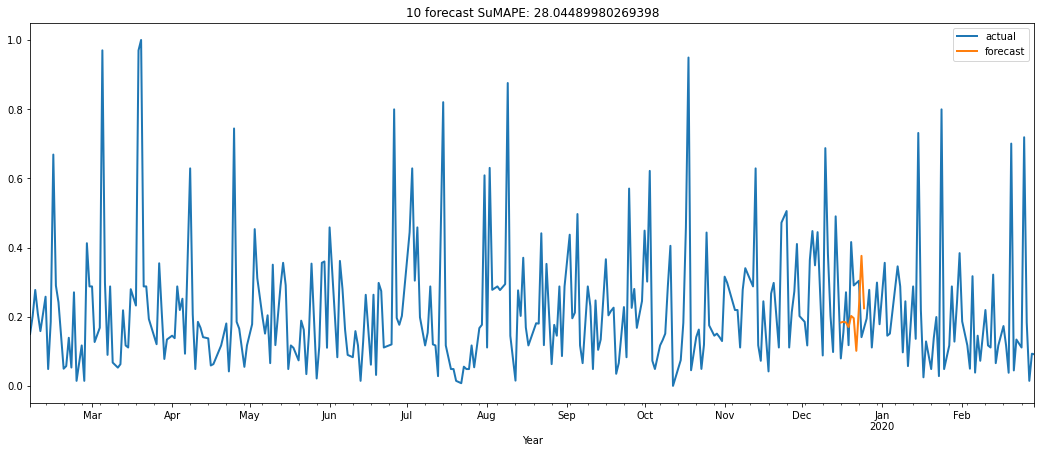

In [107]:
#Evaluate model
prediction = my_model_2.predict(10, use_full_output_length=True)
ts_transformed.univariate_component(0).plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")
plt.title('10 forecast SuMAPE: {}'.format(sumape(prediction.slice_intersect(val_transformed), val_transformed.univariate_component(0))))
plt.legend();